# Building offline iPhone spam classifier using coreml

iOS 11 introduced message extension to filter spam messages and coreml to build custom machine learned models to predict spam or not. In this article I’ll go over all the steps I took to build a machine learning model and how I added it to an iphone project.

## Load Modules

In [1]:
%matplotlib inline
from io import open
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import pickle
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
#from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
plt.style.use('ggplot')
pd.options.display.mpl_style = 'default'

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days
/Users/darshansonde/anaconda2/envs/education/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


# Data

SMSSpamCollection lets load and understand the data.


In [2]:
fpath = '/Users/darshansonde/Code/ml/DSpam/ML/'
file_name = fpath + 'SMS2017India.csv'
with open(file_name) as f:
    corpus = f.readlines()

print("there are {} messages".format(len(corpus)))
    

corpus = [x.strip() for x in corpus]

for i,message in enumerate(corpus[:10]):
    print(i, message)

there are 433 messages
(0, u'ham\tDear Customer, Purchase of INR AMT has been made on Debit Card linked to Acct on 30-Oct-17. Info: IIN*PAYTM      . The Available Balance is INR AMT.')
(1, u'ham\tDear Customer, Govt. of India has mandated Aadhaar updation in bank accounts. Ensure uninterrupted banking services by updating your Aadhaar at goo.gl/Bzh9iA')
(2, u'ham\tDear Customer, your Account XX has been debited with INR AMT on 06-Oct-17. Info: DECS*S.B.I., R.A.C.P.C.,*044. The Available Balance is INR AMT')
(3, u'ham\tAdded Rs. AMT to your Paytm wallet. Transaction ID: DIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGITDIGIT. Current Balance: 1283.52. Rs100 Cashback on Bus Tickets')
(4, u'ham\tWe have received a Paytm login request from a new phone at 02:09 PM, 23 October.If you did not attempt this, please raise a query at paytm.com/care or call us at 0120-3888388')
(5, u'ham\tUse DIGITDIGITDIGITDIGITDIGITDIGIT as your login OTP. OTP is confidential. Paytm never calls you asking for OTP. Sh

There spam and ham messages are separated by tab. we can use a csv loader to read.

In [3]:
with open(file_name,encoding='UTF-8') as f:
    messages = pd.read_csv(f, sep='\t', quoting=csv.QUOTE_NONE, names=['label', 'message'])

messages['message'] = messages['message'].map(lambda text:text)
messages.head()

,label,message
0,ham,"Dear Customer, Purchase of INR AMT has been ma..."
1,ham,"Dear Customer, Govt. of India has mandated Aad..."
2,ham,"Dear Customer, your Account XX has been debite..."
3,ham,Added Rs. AMT to your Paytm wallet. Transactio...
4,ham,We have received a Paytm login request from a ...


In [4]:
messages.groupby('label').describe()

message
label                                                          
ham   count                                                  35
      unique                                                 35
      top     Dear Customer, Purchase of INR AMT has been ma...
      freq                                                    1
spam  count                                                 397
      unique                                                382
      top     Grab your best deal now! The Great Crossword S...
      freq                                                    3

In [5]:
messages['length'] = messages['message'].map(lambda text:len(text))
messages.head()

,label,message,length
0,ham,"Dear Customer, Purchase of INR AMT has been ma...",148
1,ham,"Dear Customer, Govt. of India has mandated Aad...",157
2,ham,"Dear Customer, your Account XX has been debite...",143
3,ham,Added Rs. AMT to your Paytm wallet. Transactio...,159
4,ham,We have received a Paytm login request from a ...,174


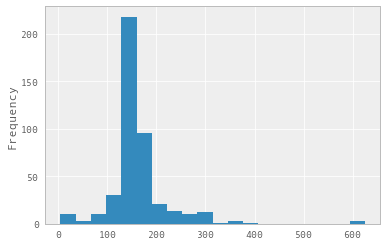

In [6]:
messages.length.plot(bins=20, kind='hist')

In [7]:
messages.length.describe()

count    432.000000
mean     164.111111
std       63.480758
min        4.000000
25%      147.000000
50%      158.000000
75%      160.000000
max      625.000000
Name: length, dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x112da34d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114b24110>], dtype=object)

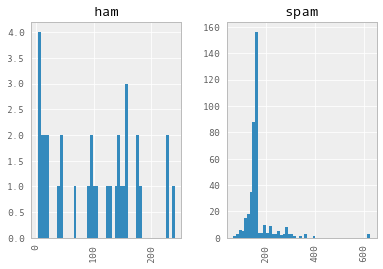

In [8]:
messages.hist(column='length', by='label', bins=50)


# Processing Data

we need to break the sentences into tokens and stem before we can use it. lets create a method for tokenizing the words.

In [9]:
print("removing punctuations: "+string.punctuation)
stemmer = PorterStemmer()

def tokenize(message):
    """ removes punctuation and tokenizes the words and stems each word.
    """
    msg = "".join([ch for ch in message if ch not in string.punctuation]) # get rid of punctuations
    tokens = word_tokenize(msg) 
    #stems = [stemmer.stem(x).lower() for x in tokens] #correct way to do
    stems = [x.lower() for x in tokens] #iOS does not have porterstemmer, we are going to not use stem for now
    return stems

messages.message.head().apply(tokenize)

removing punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


0    [dear, customer, purchase, of, inr, amt, has, ...
1    [dear, customer, govt, of, india, has, mandate...
2    [dear, customer, your, account, xx, has, been,...
3    [added, rs, amt, to, your, paytm, wallet, tran...
4    [we, have, received, a, paytm, login, request,...
Name: message, dtype: object

# Feature Vector

we need to convert the tokenized words into a vector to feed into the ml algorithm. we will create a TF-IDF feature vector from the sentence.

1. create count vector
2. convert convert vector into tf-idf vector


In [10]:
fv = CountVectorizer(analyzer=tokenize).fit(messages.message)

print("Total number of words in array", len(fv.vocabulary_))

('Total number of words in array', 2338)


Lets try to test how different words are represented in the CountVector.

In [11]:
print(fv.transform(["U dun"]))

print("Second:")
print(fv.transform(["dun U"]))


  (0, 2167)	1
Second:
  (0, 2167)	1


Notice sentences have same count vector generated. when we fit the vectorizer it creates a vocabulary. this vocabulary is used to create a count vector for all sentences.

Lets try to vectorize a full sentence from our corpus.

In [12]:
print(fv.transform([messages.message[3]]))

  (0, 54)	1
  (0, 356)	1
  (0, 384)	1
  (0, 461)	1
  (0, 599)	1
  (0, 633)	1
  (0, 756)	1
  (0, 815)	1
  (0, 1184)	1
  (0, 1552)	1
  (0, 1618)	1
  (0, 1812)	1
  (0, 1814)	1
  (0, 2107)	1
  (0, 2120)	1
  (0, 2150)	1
  (0, 2243)	1
  (0, 2326)	1



### Count Vector Vocabulary (words_array)

iPhone does not have a CountVectorizer so we would need to do this step if we are to analyze a sentence. we will use the vocabulary of countvectorizer and save into words array file.

words array file is the file with count positions of words and frequency of its occurance.

this is inturn used to calculate term frequency.

tf = Ft / Count(F)

Ft => frequency of term t in current document
Count(F) => total number of words in corpus. (max of Ft in words array)

lets save this file

In [13]:
import json
with open('words_array.json', 'wb') as fp:
    json.dump(fv.vocabulary_, fp)

# Messages Feature Vector

Let's compose the feature vector for our entire corpus.

In [14]:
messages_fv = fv.transform(messages.message)
print(messages_fv.shape)

(432, 2338)


We will use TF-IDF transformer to transform the count vector of corpus into TFIDF vector.

In [15]:
tfidf = TfidfTransformer().fit(messages_fv)

# test tfidf of same message as before.
t = tfidf.transform(fv.transform([messages.message[3]]))
print(t)

  (0, 2326)	0.105471941541
  (0, 2243)	0.196773143001
  (0, 2150)	0.266910001602
  (0, 2120)	0.0819653738833
  (0, 2107)	0.311691861045
  (0, 1814)	0.238183115152
  (0, 1812)	0.160623402245
  (0, 1618)	0.224123234719
  (0, 1552)	0.0743681404273
  (0, 1184)	0.257999403639
  (0, 815)	0.266910001602
  (0, 756)	0.277815692125
  (0, 633)	0.182713262567
  (0, 599)	0.311691861045
  (0, 461)	0.228375740085
  (0, 384)	0.238183115152
  (0, 356)	0.291875572558
  (0, 54)	0.311691861045


We see that the values are all normalized and weights are given according to TF-IDF importance. this gives more relevancy for the model to use.

Lets compute the tfidf of the entire corpus.

In [16]:
messages_tfidf = tfidf.transform(messages_fv)
print(messages_tfidf.shape)

(432, 2338)


### IDF 

words idf is simple list of words and their IDF values

idf = log(N/Nt)

N => number of documents
N => number of documets with word t

we need to compute tfidf of sentence in iOS and we will need the words_idf values as input for computing the vector. lets save the idf array into a file. This is later used in the iOS code.

In [17]:
idf = {}
idf['idf'] = tfidf.idf_.tolist()

with open('words_idf.json', 'wb') as fp:
    json.dump(idf, fp)

print("IDF of corpus :", tfidf.idf_)


('IDF of corpus :', array([ 5.12482758,  6.37759055,  6.37759055, ...,  5.97212544,
        4.99129619,  6.37759055]))


# Model Training

For the model we will use a simple Linear SVM. SVM seems to be getting the most accurate results and we can easily use this model in iPhone as well. lets create and train an Linear SVM model.

In [18]:
%time spam_detector = LinearSVC().fit(messages_tfidf, messages.label)

predictions = spam_detector.predict(messages_tfidf)

print('accuracy', accuracy_score(messages['label'], predictions))
print('confusion matrix\n', confusion_matrix(messages['label'], predictions))
print('(row=expected, col=predicted)')


CPU times: user 2.62 ms, sys: 1.23 ms, total: 3.84 ms
Wall time: 5.14 ms
('accuracy', 0.99768518518518523)
('confusion matrix\n', array([[ 34,   1],
       [  0, 397]]))
(row=expected, col=predicted)


It looks like the model has got a really good accuracy. confusion matrix is also showing great results. 

Lets plot this and view this a little nicely

Text(0.5,0,u'predicted label')

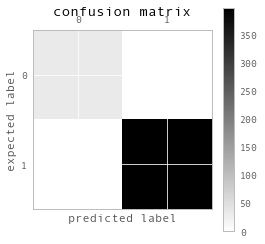

In [19]:
plt.matshow(confusion_matrix(messages['label'], predictions), cmap=plt.cm.binary, interpolation='nearest')
plt.title('confusion matrix')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')

In [20]:
print(classification_report(messages['label'], predictions))

             precision    recall  f1-score   support

        ham       1.00      0.97      0.99        35
       spam       1.00      1.00      1.00       397

avg / total       1.00      1.00      1.00       432



# Convert to CoreML

In [21]:
import coremltools
coreml_model = coremltools.converters.sklearn.convert(spam_detector, "message", "spam_or_not")

#set parameters of the model
coreml_model.short_description = "Classify whether message is spam or not"
coreml_model.input_description["message"] = "TFIDF of message to be classified"
coreml_model.output_description["spam_or_not"] = "Whether message is spam or not"
#save the model
coreml_model.save("SpamMessageClassifier.mlmodel")